In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/'Colab Notebooks'/AnyoneAI/final_project/main"
    %cd $ROOT_DIR

/content/drive/MyDrive/Colab Notebooks/AnyoneAI/final_project/main


In [4]:
pip install boto3 python_dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from src import config, data_utils, evaluation, plot

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [6]:
dataset = pd.read_csv('clean_data.csv')

In [7]:
# perform random downsampling
sample_size = dataset['TARGET_LABEL_BAD=1'].value_counts().min()
dataset_resampled = pd.concat([dataset[dataset['TARGET_LABEL_BAD=1'] == c].sample(sample_size) for c in dataset['TARGET_LABEL_BAD=1'].unique()])
print('Resampled dataset shape %s' % dataset_resampled['TARGET_LABEL_BAD=1'].value_counts())

Resampled dataset shape 1    13018
0    13018
Name: TARGET_LABEL_BAD=1, dtype: int64


In [8]:
dataset_resampled

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,COMPANY,...,PRODUCT,AGE,TARGET_LABEL_BAD=1,HAS_DEPENDANTS,HAS_RESIDENCE,MONTHLY_INCOMES_TOT,HAS_CARDS,HAS_BANKING_ACCOUNTS,HAS_PERSONAL_ASSETS,HAS_CARS
17449,15 - 30,Carga,F,single,2,BA,N,0 - 6 months,1,Y,...,1,26 - 35,1,True,False,[0 - 650],False,True,False,True
1338,1 - 14,Carga,F,single,3,RS,Y,0 - 6 months,1,Y,...,1,36 - 45,1,True,True,[0 - 650],False,False,False,False
44704,15 - 30,Carga,F,single,0,RS,Y,+ 1 year,0,N,...,7,36 - 45,1,False,True,[0 - 650],False,True,False,True
17194,15 - 30,Carga,F,single,0,RS,Y,0 - 6 months,0,Y,...,1,36 - 45,1,False,True,[650 - 1320],False,False,False,True
12178,15 - 30,Web,F,other,0,SP,N,+ 1 year,1,N,...,1,46 - 60,1,False,False,[0 - 650],False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39696,15 - 30,Web,F,married,2,PB,Y,+ 1 year,1,N,...,1,36 - 45,0,True,True,[0 - 650],True,False,False,False
46069,15 - 30,Web,F,married,0,PE,Y,0 - 6 months,1,Y,...,1,18 - 25,0,False,True,[0 - 650],False,False,False,False
19848,15 - 30,Web,F,other,0,SP,Y,+ 1 year,1,N,...,1,> 60,0,False,True,[0 - 650],False,False,False,False
23525,1 - 14,Web,F,married,0,GO,Y,6 months - 1 year,1,N,...,1,36 - 45,0,False,True,[1320 - 3323],False,False,False,False


In [10]:
# first split in sets
app_train_set, app_val_set, app_test_set = data_utils.get_feature_in_set(dataset_resampled)

In [11]:
# second split features and target
train_prep, y_train, val_prep, y_val, test_prep, y_test = data_utils.get_feature_target(app_train_set,app_val_set,app_test_set)

In [12]:
app_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18745 entries, 42780 to 17447
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PAYMENT_DAY                  18745 non-null  object
 1   APPLICATION_SUBMISSION_TYPE  18745 non-null  object
 2   SEX                          18745 non-null  object
 3   MARITAL_STATUS               18745 non-null  object
 4   QUANT_DEPENDANTS             18745 non-null  int64 
 5   RESIDENCIAL_STATE            18745 non-null  object
 6   FLAG_RESIDENCIAL_PHONE       18745 non-null  object
 7   MONTHS_IN_RESIDENCE          18745 non-null  object
 8   FLAG_EMAIL                   18745 non-null  int64 
 9   COMPANY                      18745 non-null  object
 10  FLAG_PROFESSIONAL_PHONE      18745 non-null  object
 11  PRODUCT                      18745 non-null  int64 
 12  AGE                          18745 non-null  object
 13  TARGET_LABEL_BAD=1         

In [13]:
# third apply preprocess in sets
X_train, X_val, X_test, columns = data_utils.preprocess_data(train_prep,val_prep,test_prep)

Input train data shape:  (18745, 20)
Input val data shape:  (2083, 20)
Input test data shape:  (5208, 20) 

cat_cols:  Index(['PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'SEX', 'MARITAL_STATUS',
       'RESIDENCIAL_STATE', 'FLAG_RESIDENCIAL_PHONE', 'MONTHS_IN_RESIDENCE',
       'COMPANY', 'FLAG_PROFESSIONAL_PHONE', 'AGE', 'HAS_DEPENDANTS',
       'HAS_RESIDENCE', 'MONTHLY_INCOMES_TOT', 'HAS_CARDS',
       'HAS_BANKING_ACCOUNTS', 'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
['QUANT_DEPENDANTS', 'FLAG_EMAIL', 'PRODUCT']
Index(['PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'SEX',
       'FLAG_RESIDENCIAL_PHONE', 'COMPANY', 'FLAG_PROFESSIONAL_PHONE',
       'HAS_DEPENDANTS', 'HAS_RESIDENCE', 'HAS_CARDS', 'HAS_BANKING_ACCOUNTS',
       'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
Index(['MARITAL_STATUS', 'RESIDENCIAL_STATE', 'MONTHS_IN_RESIDENCE', 'AGE',
       'MONTHLY_INCOMES_TOT'],
      dtype='object')


In [14]:
pd.DataFrame(X_train, columns=columns)

,transform_cat__MARITAL_STATUS_married,transform_cat__MARITAL_STATUS_other,transform_cat__MARITAL_STATUS_single,transform_cat__RESIDENCIAL_STATE_AC,transform_cat__RESIDENCIAL_STATE_AL,transform_cat__RESIDENCIAL_STATE_AM,transform_cat__RESIDENCIAL_STATE_AP,transform_cat__RESIDENCIAL_STATE_BA,transform_cat__RESIDENCIAL_STATE_CE,transform_cat__RESIDENCIAL_STATE_DF,...,transform_bin__FLAG_PROFESSIONAL_PHONE,transform_bin__HAS_DEPENDANTS,transform_bin__HAS_RESIDENCE,transform_bin__HAS_CARDS,transform_bin__HAS_BANKING_ACCOUNTS,transform_bin__HAS_PERSONAL_ASSETS,transform_bin__HAS_CARS,transform_num__QUANT_DEPENDANTS,transform_num__FLAG_EMAIL,transform_num__PRODUCT
0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18740,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18741,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18742,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0
18743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,1.0


In [15]:
# logistic regression
model = LogisticRegression(max_iter=500)


In [16]:
# define the parameter grid to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

# create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.1}
Best Score:  0.5868231528407575


In [17]:
print("model score: %.3f" % grid_search.score(X_val, y_val))
y_hat = grid_search.predict(X_test)

model score: 0.580


Model Performance metrics:
------------------------------
Accuracy: 0.5883256528417818
Precision: 0.5965750696933493
Recall: 0.5697984024343857
F1 Score: 0.5828793774319067

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      2629
           1       0.58      0.61      0.59      2579

    accuracy                           0.59      5208
   macro avg       0.59      0.59      0.59      5208
weighted avg       0.59      0.59      0.59      5208


Prediction Confusion Matrix:
------------------------------
      0     1
0  1498  1131
1  1013  1566


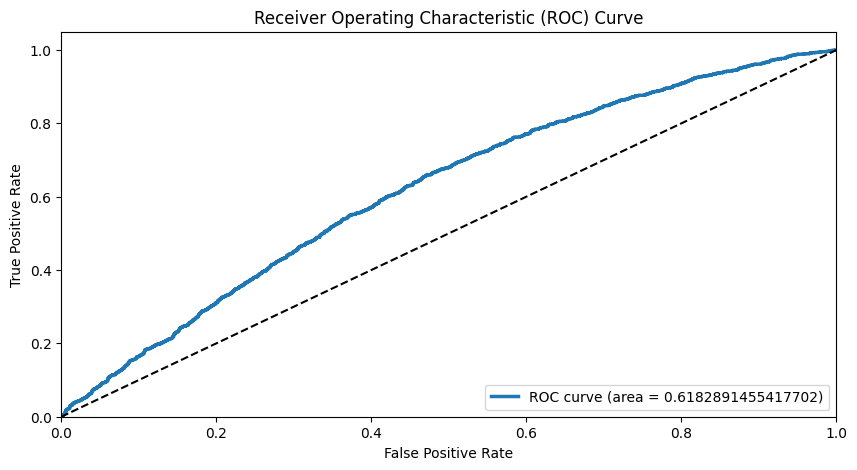

0.6182891455417702

In [18]:
accuracy = evaluation.get_performance(y_hat, y_test)
evaluation.plot_roc(grid_search, y_test, X_test)

In [19]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [20]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(40, 50):
		rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

In [21]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [22]:
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X_train, y_train)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()